<a href="https://colab.research.google.com/github/Gradsmith/Deep-Learning-HW4/blob/main/DL2022_HW4_P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import transformers
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [ ]:
# Clone the Persian poems corpus repo and copy poems of 10 different poets to a new folder.
!git clone https://github.com/amnghd/Persian_poems_corpus
!mkdir data

!cp /content/Persian_poems_corpus/normalized/amir_norm.txt /content/data
!cp /content/Persian_poems_corpus/normalized/anvari_norm.txt /content/data
!cp /content/Persian_poems_corpus/normalized/asad_norm.txt /content/data
!cp /content/Persian_poems_corpus/normalized/attar_norm.txt /content/data
!cp /content/Persian_poems_corpus/normalized/bahar_norm.txt /content/data
!cp /content/Persian_poems_corpus/normalized/ferdousi_norm.txt /content/data
!cp /content/Persian_poems_corpus/normalized/khaghani_norm.txt /content/data
!cp /content/Persian_poems_corpus/normalized/moulavi_norm.txt /content/data
!cp /content/Persian_poems_corpus/normalized/saadi_norm.txt /content/data
!cp /content/Persian_poems_corpus/normalized/sanaee_norm.txt /content/data

!rm -r Persian_poems_corpus

Cloning into 'Persian_poems_corpus'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 45.21 MiB | 17.12 MiB/s, done.
Resolving deltas: 100% (3/3), done.
mkdir: cannot create directory ‘data’: File exists


In [ ]:
# Create training and test datasets from the selected poems.
dataset_train = pd.DataFrame()
dataset_test = pd.DataFrame()
labels_dict = {}

# Each poet has a unique label denoted by l.
l = 0
for filename in sorted(os.listdir('./data')):
    labels_dict.update({l: filename.split('_')[0]})

    f = os.path.join('./data', filename)
    poems = pd.read_csv(f, header=None, names=['Verse'])[:10000]
    poems['Label'] = l

    dataset_train = pd.concat([dataset_train, poems[:8000]])
    dataset_test = pd.concat([dataset_test, poems[8000:]])

    l = l + 1

dataset_train.reset_index(inplace=True, drop=True)
dataset_test.reset_index(inplace=True, drop=True)

In [ ]:
# Save the training and test datasets to csv files.
dataset_train.to_csv('dataset_train.csv')
dataset_test.to_csv('dataset_test.csv')

In [ ]:
# Find the maximum length of verses for BERT input padding.
verse_max_length = max([len(dataset_train['Verse'][i].split()) for i in range(80000)])

# Part A: Text Classification Using Bert With a Single FC Layer

In the first part, we add a single fully connected layer to the output of a pretrained BERT model and try to build a poem classifier.

In [ ]:
# Define a dataset class for the BERT model.
class BertDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length):
        super().__init__()
        self.dataset = pd.read_csv(file_path).iloc[:, 1:]
        self.max_length = max_length
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        text = self.dataset.iloc[index, 0]
        
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            padding = 'max_length',
            truncation=True,
            add_special_tokens = True,
            return_attention_mask = True,
            max_length = self.max_length,
        )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(self.dataset.iloc[index, 1], dtype=torch.long)
            }

In [ ]:
# Create a BERT tokenizer from the pretrained model.
tokenizer = transformers.BertTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

In [ ]:
# Define BERT datasets and dataloaders to train our model.
dataset_train = BertDataset('./dataset_train.csv', tokenizer, max_length=verse_max_length)
dataset_test = BertDataset('./dataset_test.csv', tokenizer, max_length=verse_max_length)

dataloader_train = DataLoader(dataset=dataset_train, shuffle=True, batch_size=64)
dataloader_test = DataLoader(dataset=dataset_test, shuffle=True, batch_size=64)

In [ ]:
# Define a nn module using the pretrained BERT and a fc layer for text classification.
class BERT(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert_model = transformers.BertModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")
        self.fc = nn.Linear(768, 10)
        
    def forward(self, ids, mask, token_type_ids):
        _, out = self.bert_model(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        out = self.fc(out)
        
        return out

Now, we instantiate a BERT poem classifier and only train the fully connected layer.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Instantiate the BERT classifier and define the loss function.
model = BERT().to(device)
loss_fn = nn.CrossEntropyLoss()

# Initialize Optimizer
optimizer= optim.Adam(model.parameters(), lr= 1e-4)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Freeze the BERT parameters so we can just train the fc layer.
for param in model.bert_model.parameters():
    param.requires_grad = False

In [ ]:
# Define a function for training the BERT classifier.
def trainBERT(epochs, dataloader, model, loss_fn, optimizer):
    model.train()
    for epoch in range(epochs):
        running_loss = 0
        accuracy = 0
        loop = tqdm(enumerate(dataloader, 1), total=len(dataloader))
        for batch, data in loop:
            ids = data['ids'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            mask = data['mask'].to(device)
            label = data['target'].to(device)
            
            # Compute the output and loss of the model.
            optimizer.zero_grad()
            output = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            # Calculate the accuracy.
            pred = output.argmax(dim=1)
            accuracy += (sum(pred==label)/len(label)).item()

            # Show progress while training
            loop.set_description(f'Epoch={epoch+1}/{epochs}')
            loop.set_postfix(Loss=running_loss/batch, Accuracy = accuracy/batch)

    return model

In [ ]:
# Training the model
model = trainBERT(5, dataloader_train, model, loss_fn, optimizer)

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

In [ ]:
# Define a function for model evaluation.
def evalBERT(dataloader, model, loss_fn):
    model.eval()
    running_loss = 0

    targets = torch.tensor([]).to(device)
    predictions = torch.tensor([]).to(device)

    loop = tqdm(dataloader, total=len(dataloader))
    with torch.no_grad():
        for data in loop:
            ids = data['ids'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            mask = data['mask'].to(device)
            label = data['target'].to(device)
            
            output = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            pred = output.argmax(dim=1)
            
            running_loss += loss_fn(output, label).item() * len(label)

            predictions = torch.cat((predictions, pred))
            targets = torch.cat((targets, label))

    targets = targets.to('cpu')
    predictions = predictions.to('cpu')

    loss = running_loss/(len(dataloader.dataset))
    accuracy = accuracy_score(targets, predictions)
    f1_micro = f1_score(targets, predictions, average='micro')
    cf = confusion_matrix(targets, predictions)

    return loss, accuracy, f1_micro, cf

In [ ]:
# Model evaluation
loss_train, accuracy_train, f1_micro_train, cf_train = evalBERT(dataloader_train, model, loss_fn)
loss_test, accuracy_test, f1_micro_test, cf_test = evalBERT(dataloader_test, model, loss_fn)

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

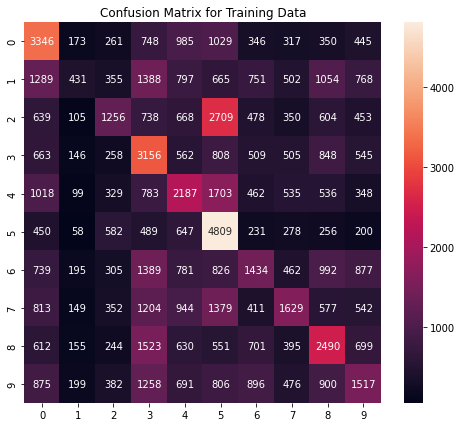

Training Loss: 2.027083546638489
Training Accuracy: 27.82 %
Training F1 Score (micro): 27.82 %


In [ ]:
# Plot confussion matrix and print the loss, accuracy and f1 score for training data.
plt.figure(figsize=(8, 7))
sns.heatmap(cf_train, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Training Data')
plt.show()

print(f"Training Loss: {loss_train}")
print(f"Training Accuracy: {accuracy_train*100:.2f} %")
print(f"Training F1 Score (micro): {f1_micro_train*100:.2f} %")

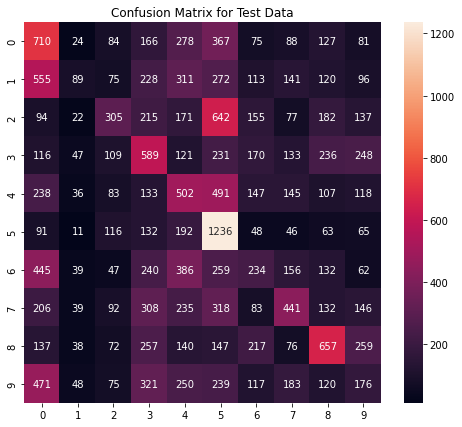

Test Loss: 2.1064526721954344
Test Accuracy: 24.70 %
Test F1 Score (micro): 24.70 %


In [ ]:
# Plot confussion matrix and print the loss, accuracy and f1 score for test data.
plt.figure(figsize=(8, 7))
sns.heatmap(cf_test, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Test Data')
plt.show()

print(f"Test Loss: {loss_test}")
print(f"Test Accuracy: {accuracy_test*100:.2f} %")
print(f"Test F1 Score (micro): {f1_micro_test*100:.2f} %")

We can see that the accuracy of our model is around 28 and 24.5 percent for training and test datasets, respectively. 

In [ ]:
# Save the model.
torch.save(model, './BERT_Classifier.h5')

# Part B: Fine-Tuning the Whole Model

In contrast to part A, now we fine-tune the whole model once with the SGD optimizer and again with the Adam optimizer.

## SGD Optimizer

In [ ]:
# Instantiate the BERT classifier and define the loss function.
model_finetuned = BERT().to(device)
loss_fn = nn.CrossEntropyLoss()

# Initialize Optimizer
optimizer= optim.SGD(model_finetuned.parameters(), lr= 1e-4)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Training the model
model_finetuned = trainBERT(5, dataloader_train, model_finetuned, loss_fn, optimizer)

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

In [ ]:
# Model evaluation
loss_train, accuracy_train, f1_micro_train, cf_train = evalBERT(dataloader_train, model_finetuned, loss_fn)
loss_test, accuracy_test, f1_micro_test, cf_test = evalBERT(dataloader_test, model_finetuned, loss_fn)

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

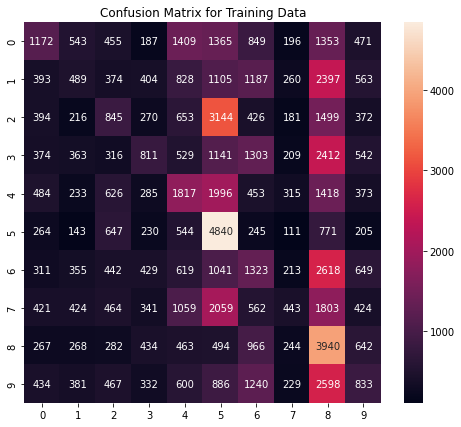

Training Loss: 2.17006221370697
Training Accuracy: 20.64 %
Training F1 Score (micro): 20.64 %


In [ ]:
# Plot confussion matrix and print the loss, accuracy and f1 score for training data.
plt.figure(figsize=(8, 7))
sns.heatmap(cf_train, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Training Data')
plt.show()

print(f"Training Loss: {loss_train}")
print(f"Training Accuracy: {accuracy_train*100:.2f} %")
print(f"Training F1 Score (micro): {f1_micro_train*100:.2f} %")

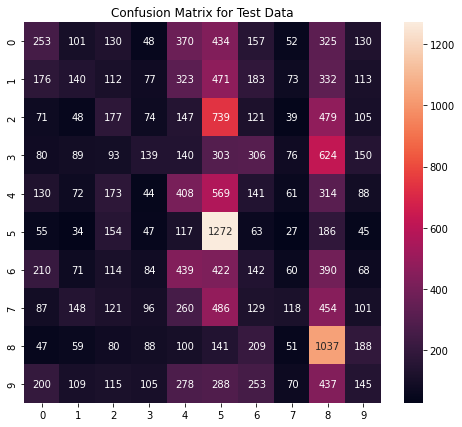

Test Loss: 2.2156719230651856
Test Accuracy: 19.16 %
Test F1 Score (micro): 19.16 %


In [ ]:
# Plot confussion matrix and print the loss, accuracy and f1 score for test data.
plt.figure(figsize=(8, 7))
sns.heatmap(cf_test, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Test Data')
plt.show()

print(f"Test Loss: {loss_test}")
print(f"Test Accuracy: {accuracy_test*100:.2f} %")
print(f"Test F1 Score (micro): {f1_micro_test*100:.2f} %")

We can see that the results are not satisfactory.

In [ ]:
# Save the model.
torch.save(model_finetuned, './BERT_Classifier_FineTuned_SGD.h5')

## Adam Optimizer

In [ ]:
# Instantiate the BERT classifier and define the loss function.
model_finetuned = BERT().to(device)
loss_fn = nn.CrossEntropyLoss()

# Initialize Optimizer
optimizer= optim.Adam(model_finetuned.parameters(), lr= 1e-4)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Training the model
model_finetuned = trainBERT(5, dataloader_train, model_finetuned, loss_fn, optimizer)

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

In [ ]:
# Model evaluation
loss_train, accuracy_train, f1_micro_train, cf_train = evalBERT(dataloader_train, model_finetuned, loss_fn)
loss_test, accuracy_test, f1_micro_test, cf_test = evalBERT(dataloader_test, model_finetuned, loss_fn)

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

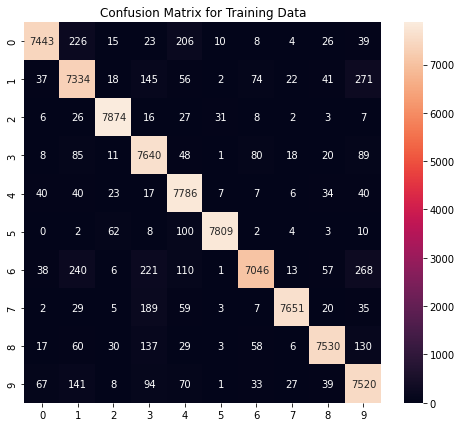

Training Loss: 0.18185132870674134
Training Accuracy: 94.54 %
Training F1 Score (micro): 94.54 %


In [ ]:
# Plot confussion matrix and print the loss, accuracy and f1 score for training data.
plt.figure(figsize=(8, 7))
sns.heatmap(cf_train, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Training Data')
plt.show()

print(f"Training Loss: {loss_train}")
print(f"Training Accuracy: {accuracy_train*100:.2f} %")
print(f"Training F1 Score (micro): {f1_micro_train*100:.2f} %")

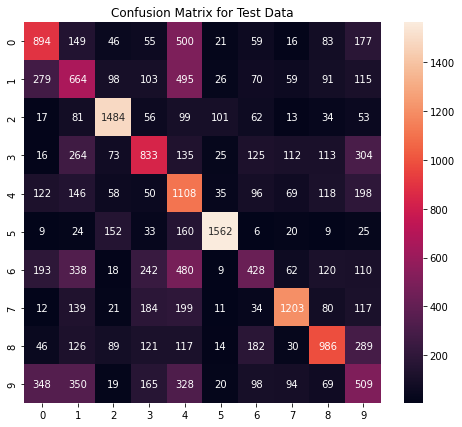

Test Loss: 2.198149769973755
Test Accuracy: 48.35 %
Test F1 Score (micro): 48.35 %


In [ ]:
# Plot confussion matrix and print the loss, accuracy and f1 score for test data.
plt.figure(figsize=(8, 7))
sns.heatmap(cf_test, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Test Data')
plt.show()

print(f"Test Loss: {loss_test}")
print(f"Test Accuracy: {accuracy_test*100:.2f} %")
print(f"Test F1 Score (micro): {f1_micro_test*100:.2f} %")

As can be seen, fine-tuning the whole model with the Adam optimizer has significantly improved the accuracy of our poem classifier.

In [ ]:
# Save the model.
torch.save(model_finetuned, './BERT_Classifier_FineTuned_Adam.h5')

# Part C: Perplexity of the Models

In the last part, we compute the perplexity for our models using an unbiased dataset of 1000 verses from 10 different poets.

In [ ]:
# Create an unbiased dataset of 1000 verses from 10 poets.
unbiased_sample1K = pd.read_csv('./dataset_test.csv')
unbiased_sample1K = pd.concat([unbiased_sample1K.iloc[i*2000:i*2000+100, 1:] for i in range(10)])
unbiased_sample1K.reset_index(inplace=True, drop=True)
unbiased_sample1K.to_csv('unbiased_sample1K.csv')
unbiased_sample1K

,Verse,Label
0,گر خار حوادث جگر بنده بخارید,0
1,ور زهر چشانید مراگردون یک چند,0
2,چون طلعت تو دیدم و لفظ تو شنیدم,0
3,آن خار همه گل شد و آن زهر همه قند,0
4,تا در حد و در ناحیت شام و قهستان,0
...,...,...
995,ز بهر زاد آنجا راست اینجا زادن حوا,9
996,تو پنداری که بر بازیست این میدان چون مینو,9
997,تو پنداری که بر هرزه ست این الوان چون مینا,9
998,وگر نز بهر دینستی در اندر بنددی گردون,9


In [ ]:
# Define a BERT dataset and dataloader to train our model.
dataset_sample1k = BertDataset('./unbiased_sample1K.csv', tokenizer, max_length=verse_max_length)

dataloader_sample1k = DataLoader(dataset=dataset_sample1k, batch_size=64)

According to the definition of perplexity, we can easily compute it by finding the exponential of the cross-entropy loss.

$Perplexity = P(w_1w_2...w_N)^{-\frac1N} = b^{-\frac1N\Sigma_{i=1}^Nlog_bq(x_i)} = e^{-\frac1N\Sigma_{i=1}^Nlog_eq(x_i)} = e^{Cross Entropy Loss}$ 

In [ ]:
# Compute the cross-entropy loss of our models.
loss_model = evalBERT(dataloader_sample1k, model, loss_fn)[0]
loss_model_finetuned = evalBERT(dataloader_sample1k, model_finetuned, loss_fn)[0]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
# Calculate the perplexity of the models.
perplexity_model = np.exp(loss_model)
perplexity_model_finetuned = np.exp(loss_model_finetuned)

print(f'Perplexity Before Fine-Tuning = {perplexity_model}')
print(f'Perplexity After Fine-Tuning = {perplexity_model_finetuned}')

Perplexity Before Fine-Tuning = 7.9084846665202395
Perplexity After Fine-Tuning = 7.053777693387242


As expected, the perplexity of the model reduced after the fine-tuning. This shows that the fine-tuned model has a better understanding of the context and thus, it can classify poems with a higher accuracy.